<a href="https://colab.research.google.com/github/xiulinyang/Aspect_Detection/blob/main/LTP_supervisedBERT.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import pandas as pd
import numpy as np
from tqdm import tqdm, trange

In [2]:
from google.colab import drive
drive.mount('/content/gdrive') 

Mounted at /content/gdrive


In [3]:
data_train = pd.read_csv("/content/gdrive/MyDrive/in_topic/tagged_ner_train.tsv", delimiter='\*\*', names=['sentence', 'token', 'tag'],engine='python')
data_dev =pd.read_csv("/content/gdrive/MyDrive/in_topic/tagged_ner_dev.tsv", delimiter='\*\*', names=['sentence', 'token', 'tag'],engine='python')
data_test =pd.read_csv("/content/gdrive/MyDrive/in_topic/tagged_ner_test.tsv", delimiter='\*\*', names=['sentence', 'token', 'tag'],engine='python')

In [4]:
class SentenceGetter(object):#what does the object here mean?

    def __init__(self, data):
        self.n_sent = 1
        self.data = data
        self.empty = False
        agg_func = lambda s: [(w, t) for w, t in zip(s["token"].values.tolist(),
                                                           s["tag"].values.tolist())]
        self.grouped = self.data.groupby("sentence").apply(agg_func) #what type of data is this?
        self.sentences = [s for s in self.grouped]

    def get_next(self):
        try:
            s = self.grouped["sentence: {}".format(self.n_sent)]
            self.n_sent += 1
            return s
        except:
            return None


In [5]:
getter_train = SentenceGetter(data_train)
getter_dev = SentenceGetter(data_dev)
getter_test = SentenceGetter(data_test)


In [6]:
getter_dev.grouped

sentence
" Even if these are n't great jobs , they lead to better jobs as your skills improve .                                                                                                                                                                                      [(" , O), (Even , O), (if , O), (these , O), (...
" It 's an expression of identity . "                                                                                                                                                                                                                                       [(" , O), (It , O), ('s , O), (an , O), ( , O)...
" Policymakers will compound the damage of a $ 15 minimum wage by arbitrarily targeting businesses with a recognizable brand for uniquely-harsh wage mandates , " Michael Saltsman , the Washington , D.C.-based institute 's research director , said in a statement .     [(" , O), (Policymakers , O), (will , O), (com...
" Should parental consent be required

In [7]:
sentences_train = [[word[0] for word in sentence] for sentence in getter_train.sentences]
sentences_dev = [[word[0] for word in sentence] for sentence in getter_dev.sentences]
sentences_test = [[word[0] for word in sentence] for sentence in getter_test.sentences]

In [8]:
labels_train = [[s[1] for s in sentence] for sentence in getter_train.sentences]
labels_dev = [[s[1] for s in sentence] for sentence in getter_dev.sentences]
labels_test = [[s[1] for s in sentence] for sentence in getter_test.sentences]

In [9]:
tag_values = list(set(data_train["tag"].values))
tag_values.append("PAD")
tag2idx = {t: i for i, t in enumerate(tag_values)}


In [10]:
tag2idx

{'B-ASP': 2, 'I-ASP': 1, 'O': 0, 'PAD': 3}

In [11]:
! pip install transformers

     |████████████████████████████████| 4.2 MB 30.4 MB/s 
     |████████████████████████████████| 596 kB 63.7 MB/s 
     |████████████████████████████████| 84 kB 3.3 MB/s 
     |████████████████████████████████| 6.6 MB 66.2 MB/s 
  Attempting uninstall: pyyaml
    Found existing installation: PyYAML 3.13
    Uninstalling PyYAML-3.13:
      Successfully uninstalled PyYAML-3.13


In [12]:
import torch
from torch.utils.data import TensorDataset, DataLoader, RandomSampler, SequentialSampler
from transformers import BertTokenizer, BertConfig

from keras.preprocessing.sequence import pad_sequences
from sklearn.model_selection import train_test_split

torch.__version__


'1.11.0+cu113'

In [13]:
MAX_LEN = 125
bs = 32

In [14]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
n_gpu = torch.cuda.device_count()


In [15]:
torch.cuda.get_device_name(0)


'Tesla T4'

In [16]:
tokenizer = BertTokenizer.from_pretrained('bert-base-cased', do_lower_case=False)


Downloading:   0%|          | 0.00/208k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/29.0 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/570 [00:00<?, ?B/s]

In [17]:
def tokenize_and_preserve_labels(sentence, text_labels):
    tokenized_sentence = []
    labels = []

    for word, label in zip(sentence, text_labels):

        # Tokenize the word and count # of subwords the word is broken into
        tokenized_word = tokenizer.tokenize(word)
        n_subwords = len(tokenized_word)

        # Add the tokenized word to the final tokenized word list
        tokenized_sentence.extend(tokenized_word)

        # Add the same label to the new list of labels `n_subwords` times
        labels.extend([label] * n_subwords)

    return tokenized_sentence, labels


In [18]:
tokenized_texts_and_labels_train = [
    tokenize_and_preserve_labels(sent, labs)
    for sent, labs in zip(sentences_train, labels_train)
]

tokenized_texts_and_labels_dev = [
    tokenize_and_preserve_labels(sent, labs)
    for sent, labs in zip(sentences_dev, labels_dev)
]

tokenized_texts_and_labels_test = [
    tokenize_and_preserve_labels(sent, labs)
    for sent, labs in zip(sentences_test, labels_test)
]



In [19]:
tokenized_texts_train = [token_label_pair[0] for token_label_pair in tokenized_texts_and_labels_train]
labels_train = [token_label_pair[1] for token_label_pair in tokenized_texts_and_labels_train]
tokenized_texts_dev = [token_label_pair[0] for token_label_pair in tokenized_texts_and_labels_dev]
labels_dev = [token_label_pair[1] for token_label_pair in tokenized_texts_and_labels_dev]
tokenized_texts_test = [token_label_pair[0] for token_label_pair in tokenized_texts_and_labels_test]
labels_test = [token_label_pair[1] for token_label_pair in tokenized_texts_and_labels_test]

In [20]:
input_ids_train = pad_sequences([tokenizer.convert_tokens_to_ids(txt) for txt in tokenized_texts_train],
                          maxlen=MAX_LEN, dtype="long", value=0.0,
                          truncating="post", padding="post")
input_ids_dev = pad_sequences([tokenizer.convert_tokens_to_ids(txt) for txt in tokenized_texts_dev],
                          maxlen=MAX_LEN, dtype="long", value=0.0,
                          truncating="post", padding="post")
input_ids_test = pad_sequences([tokenizer.convert_tokens_to_ids(txt) for txt in tokenized_texts_test],
                          maxlen=MAX_LEN, dtype="long", value=0.0,
                          truncating="post", padding="post")


In [21]:
input_ids_train

array([[  107,   119,   119, ...,     0,     0,     0],
       [  107,   138,  1381, ...,     0,     0,     0],
       [  107,   138, 12207, ...,     0,     0,     0],
       ...,
       [  794,  1323, 11620, ...,     0,     0,     0],
       [  794,  6510,  1138, ...,     0,     0,     0],
       [  795,  1262,  1173, ...,     0,     0,     0]])

In [22]:
tags_train = pad_sequences([[tag2idx.get(l) for l in lab] for lab in labels_train],
                     maxlen=MAX_LEN, value=tag2idx["PAD"], padding="post",
                     dtype="long", truncating="post")
tags_dev = pad_sequences([[tag2idx.get(l) for l in lab] for lab in labels_dev],
                     maxlen=MAX_LEN, value=tag2idx["PAD"], padding="post",
                     dtype="long", truncating="post")
tags_test = pad_sequences([[tag2idx.get(l) for l in lab] for lab in labels_test],
                     maxlen=MAX_LEN, value=tag2idx["PAD"], padding="post",
                     dtype="long", truncating="post")

In [23]:
tags_train

array([[0, 0, 0, ..., 3, 3, 3],
       [0, 0, 0, ..., 3, 3, 3],
       [0, 0, 0, ..., 3, 3, 3],
       ...,
       [0, 0, 0, ..., 3, 3, 3],
       [0, 0, 0, ..., 3, 3, 3],
       [0, 0, 0, ..., 3, 3, 3]])

In [24]:
attention_masks_train = [[float(i != 0.0) for i in ii] for ii in input_ids_train]
attention_masks_dev =[[float(i != 0.0) for i in ii] for ii in input_ids_dev]
attention_masks_test =[[float(i != 0.0) for i in ii] for ii in input_ids_test]

In [25]:
tr_inputs = torch.tensor(input_ids_train)
val_inputs = torch.tensor(input_ids_dev)
tr_tags = torch.tensor(tags_train)
val_tags = torch.tensor(tags_dev)
tr_masks = torch.tensor(attention_masks_train)
val_masks = torch.tensor(attention_masks_dev)


In [26]:
train_data = TensorDataset(tr_inputs, tr_masks, tr_tags)
train_sampler = RandomSampler(train_data)
train_dataloader = DataLoader(train_data, sampler=train_sampler, batch_size=bs)

valid_data = TensorDataset(val_inputs, val_masks, val_tags)
valid_sampler = SequentialSampler(valid_data)
valid_dataloader = DataLoader(valid_data, sampler=valid_sampler, batch_size=bs)


In [27]:
import transformers
from transformers import BertForTokenClassification, AdamW

transformers.__version__


'4.19.2'

In [28]:
model = BertForTokenClassification.from_pretrained(
    "bert-base-cased",
    num_labels=len(tag2idx),
    output_attentions = False,
    output_hidden_states = False
)


Downloading:   0%|          | 0.00/416M [00:00<?, ?B/s]

Some weights of the model checkpoint at bert-base-cased were not used when initializing BertForTokenClassification: ['cls.predictions.transform.LayerNorm.weight', 'cls.predictions.transform.dense.weight', 'cls.predictions.transform.LayerNorm.bias', 'cls.predictions.bias', 'cls.predictions.transform.dense.bias', 'cls.seq_relationship.bias', 'cls.predictions.decoder.weight', 'cls.seq_relationship.weight']
- This IS expected if you are initializing BertForTokenClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForTokenClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of BertForTokenClassification were not initialized from the model checkpoint at bert-base-cas

In [29]:
model.cuda();


In [30]:
FULL_FINETUNING = True
if FULL_FINETUNING:
    param_optimizer = list(model.named_parameters())
    no_decay = ['bias', 'gamma', 'beta']
    optimizer_grouped_parameters = [
        {'params': [p for n, p in param_optimizer if not any(nd in n for nd in no_decay)],
         'weight_decay_rate': 0.01},
        {'params': [p for n, p in param_optimizer if any(nd in n for nd in no_decay)],
         'weight_decay_rate': 0.0}
    ]
else:
    param_optimizer = list(model.classifier.named_parameters())
    optimizer_grouped_parameters = [{"params": [p for n, p in param_optimizer]}]

optimizer = AdamW(
    optimizer_grouped_parameters,
    lr=3e-5,
    eps=1e-8
)


/usr/local/lib/python3.7/dist-packages/transformers/optimization.py:309: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  FutureWarning,


In [31]:
from transformers import get_linear_schedule_with_warmup

epochs = 15
max_grad_norm = 1.0

# Total number of training steps is number of batches * number of epochs.
total_steps = len(train_dataloader) * epochs

# Create the learning rate scheduler.
scheduler = get_linear_schedule_with_warmup(
    optimizer,
    num_warmup_steps=0,
    num_training_steps=total_steps
)


In [32]:
! pip install seqeval

     |████████████████████████████████| 43 kB 2.0 MB/s 
  Created wheel for seqeval: filename=seqeval-1.2.2-py3-none-any.whl size=16180 sha256=3dc22939eeffe5bf0ce3b512d3b92b061d0c70de365ca8de6388b02565445e56
  Stored in directory: /root/.cache/pip/wheels/05/96/ee/7cac4e74f3b19e3158dce26a20a1c86b3533c43ec72a549fd7
Successfully built seqeval


In [33]:
from seqeval.metrics import classification_report, accuracy_score, f1_score


In [34]:
## Store the average loss after each epoch so we can plot them.
loss_values, validation_loss_values = [], []

for _ in trange(epochs, desc="Epoch"):
    # ========================================
    #               Training
    # ========================================
    # Perform one full pass over the training set.

    # Put the model into training mode.
    model.train()
    # Reset the total loss for this epoch.
    total_loss = 0

    # Training loop
    for step, batch in enumerate(train_dataloader):
        # add batch to gpu
        batch = tuple(t.to(device) for t in batch)
        b_input_ids, b_input_mask, b_labels = batch
        # Always clear any previously calculated gradients before performing a backward pass.
        model.zero_grad()
        # forward pass
        # This will return the loss (rather than the model output)
        # because we have provided the `labels`.
        outputs = model(b_input_ids, token_type_ids=None,
                        attention_mask=b_input_mask, labels=b_labels)
        # get the loss
        loss = outputs[0]
        # Perform a backward pass to calculate the gradients.
        loss.backward()
        # track train loss
        total_loss += loss.item()
        # Clip the norm of the gradient
        # This is to help prevent the "exploding gradients" problem.
        torch.nn.utils.clip_grad_norm_(parameters=model.parameters(), max_norm=max_grad_norm)
        # update parameters
        optimizer.step()
        # Update the learning rate.
        scheduler.step()

    # Calculate the average loss over the training data.
    avg_train_loss = total_loss / len(train_dataloader)
    print("Average train loss: {}".format(avg_train_loss))

    # Store the loss value for plotting the learning curve.
    loss_values.append(avg_train_loss)


    # ========================================
    #               Validation
    # ========================================
    # After the completion of each training epoch, measure our performance on
    # our validation set.

    # Put the model into evaluation mode
    model.eval()
    # Reset the validation loss for this epoch.
    eval_loss, eval_accuracy = 0, 0
    nb_eval_steps, nb_eval_examples = 0, 0
    predictions , true_labels = [], []
    for batch in valid_dataloader:
        batch = tuple(t.to(device) for t in batch)
        b_input_ids, b_input_mask, b_labels = batch

        # Telling the model not to compute or store gradients,
        # saving memory and speeding up validation
        with torch.no_grad():
            # Forward pass, calculate logit predictions.
            # This will return the logits rather than the loss because we have not provided labels.
            outputs = model(b_input_ids, token_type_ids=None,
                            attention_mask=b_input_mask, labels=b_labels)
        # Move logits and labels to CPU
        logits = outputs[1].detach().cpu().numpy()
        label_ids = b_labels.to('cpu').numpy()

        # Calculate the accuracy for this batch of test sentences.
        eval_loss += outputs[0].mean().item()
        predictions.extend([list(p) for p in np.argmax(logits, axis=2)])
        true_labels.extend(label_ids)

    eval_loss = eval_loss / len(valid_dataloader)
    validation_loss_values.append(eval_loss)
    print("Validation loss: {}".format(eval_loss))
    pred_tags=[]
    valid_tags =[]
    for pred in predictions:
      pred_tag = [tag_values[p_i] for p, l in zip(predictions, true_labels) for p_i, l_i in zip(p, l) if tag_values[l_i] != "PAD"]
      valid_tag = [tag_values[l_i] for l in true_labels for l_i in l if tag_values[l_i] != "PAD"]
      pred_tags.append(pred_tag)
      valid_tags.append(valid_tag)
                  
    print("Validation Accuracy: {}".format(accuracy_score(valid_tags, pred_tags)))
    print("f1 score:{}".format(f1_score(valid_tags, pred_tags)))
    print("classification report: \n {}".format(classification_report(valid_tags, pred_tags, digits=4)))
    print()


Epoch:   0%|          | 0/15 [00:00<?, ?it/s]

Average train loss: 0.15335129898622496
Validation loss: 0.06424710061401129
Validation Accuracy: 0.8557701931738565


/usr/local/lib/python3.7/dist-packages/seqeval/metrics/sequence_labeling.py:171: UserWarning: PAD seems not to be NE tag.
  warnings.warn('{} seems not to be NE tag.'.format(chunk))


f1 score:0.4821066846725186


/usr/local/lib/python3.7/dist-packages/seqeval/metrics/v1.py:57: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
Epoch:   7%|▋         | 1/15 [02:54<40:46, 174.76s/it]

classification report: 
               precision    recall  f1-score   support

          AD     0.0000    0.0000    0.0000         0
         ASP     0.4760    0.4900    0.4829    716844

   micro avg     0.4744    0.4900    0.4821    716844
   macro avg     0.2380    0.2450    0.2415    716844
weighted avg     0.4760    0.4900    0.4829    716844


Average train loss: 0.05911936033346237
Validation loss: 0.05921746673993766
Validation Accuracy: 0.859873886497848
f1 score:0.5069321009598293


Epoch:  13%|█▎        | 2/15 [05:51<38:03, 175.65s/it]

classification report: 
               precision    recall  f1-score   support

          AD     0.0000    0.0000    0.0000         0
         ASP     0.5266    0.4894    0.5073    716844

   micro avg     0.5258    0.4894    0.5069    716844
   macro avg     0.2633    0.2447    0.2536    716844
weighted avg     0.5266    0.4894    0.5073    716844


Average train loss: 0.04516568014381129
Validation loss: 0.056895988527685404
Validation Accuracy: 0.8711840656590932
f1 score:0.5700712589073634


Epoch:  20%|██        | 3/15 [08:48<35:19, 176.59s/it]

classification report: 
               precision    recall  f1-score   support

          AD     0.0000    0.0000    0.0000         0
         ASP     0.5645    0.5765    0.5705    716844

   micro avg     0.5638    0.5765    0.5701    716844
   macro avg     0.2823    0.2883    0.2852    716844
weighted avg     0.5645    0.5765    0.5705    716844


Average train loss: 0.035418479916972855
Validation loss: 0.05931452685035765
Validation Accuracy: 0.877589830847763
f1 score:0.5737109658678285


Epoch:  27%|██▋       | 4/15 [11:44<32:20, 176.44s/it]

classification report: 
               precision    recall  f1-score   support

          AD     0.0000    0.0000    0.0000         0
         ASP     0.6105    0.5422    0.5743    716844

   micro avg     0.6091    0.5422    0.5737    716844
   macro avg     0.3053    0.2711    0.2872    716844
weighted avg     0.6105    0.5422    0.5743    716844


Average train loss: 0.02719551788796799
Validation loss: 0.06277620140463114
Validation Accuracy: 0.8814933440096087
f1 score:0.5968476357267951


Epoch:  33%|███▎      | 5/15 [14:42<29:26, 176.70s/it]

classification report: 
               precision    recall  f1-score   support

          AD     0.0000    0.0000    0.0000         0
         ASP     0.6103    0.5848    0.5973    716844

   micro avg     0.6094    0.5848    0.5968    716844
   macro avg     0.3052    0.2924    0.2986    716844
weighted avg     0.6103    0.5848    0.5973    716844


Average train loss: 0.02129346106645711
Validation loss: 0.06805091444402933
Validation Accuracy: 0.8760884796316685
f1 score:0.5861953984661553


Epoch:  40%|████      | 6/15 [17:40<26:34, 177.16s/it]

classification report: 
               precision    recall  f1-score   support

          AD     0.0000    0.0000    0.0000         0
         ASP     0.5704    0.6033    0.5864    716844

   micro avg     0.5700    0.6033    0.5862    716844
   macro avg     0.2852    0.3016    0.2932    716844
weighted avg     0.5704    0.6033    0.5864    716844


Average train loss: 0.01744671586319941
Validation loss: 0.07424737769179046
Validation Accuracy: 0.8794915423881493
f1 score:0.5969405905371755


Epoch:  47%|████▋     | 7/15 [20:38<23:39, 177.42s/it]

classification report: 
               precision    recall  f1-score   support

          AD     0.0000    0.0000    0.0000         0
         ASP     0.6201    0.5758    0.5972    716844

   micro avg     0.6196    0.5758    0.5969    716844
   macro avg     0.3101    0.2879    0.2986    716844
weighted avg     0.6201    0.5758    0.5972    716844


Average train loss: 0.014399776136964013
Validation loss: 0.07655046135187149
Validation Accuracy: 0.8780902812531278
f1 score:0.5904828065300451


Epoch:  53%|█████▎    | 8/15 [23:36<20:44, 177.77s/it]

classification report: 
               precision    recall  f1-score   support

          AD     0.0000    0.0000    0.0000         0
         ASP     0.5982    0.5834    0.5907    716844

   micro avg     0.5977    0.5834    0.5905    716844
   macro avg     0.2991    0.2917    0.2953    716844
weighted avg     0.5982    0.5834    0.5907    716844


Average train loss: 0.011989292761293846
Validation loss: 0.08109852857887745
Validation Accuracy: 0.8772895606045441
f1 score:0.5866759679107081


Epoch:  60%|██████    | 9/15 [26:34<17:47, 177.88s/it]

classification report: 
               precision    recall  f1-score   support

          AD     0.0000    0.0000    0.0000         0
         ASP     0.5969    0.5772    0.5869    716844

   micro avg     0.5965    0.5772    0.5867    716844
   macro avg     0.2984    0.2886    0.2934    716844
weighted avg     0.5969    0.5772    0.5869    716844


Average train loss: 0.01021817786226032
Validation loss: 0.08409828413277864
Validation Accuracy: 0.8799919927935141
f1 score:0.5970974429854872


Epoch:  67%|██████▋   | 10/15 [29:33<14:50, 178.03s/it]

classification report: 
               precision    recall  f1-score   support

          AD     0.0000    0.0000    0.0000         0
         ASP     0.6017    0.5930    0.5973    716844

   micro avg     0.6013    0.5930    0.5971    716844
   macro avg     0.3008    0.2965    0.2987    716844
weighted avg     0.6017    0.5930    0.5973    716844


Average train loss: 0.0084717315023577
Validation loss: 0.08874164335429668
Validation Accuracy: 0.8796917225502953
f1 score:0.5884389061959155


Epoch:  73%|███████▎  | 11/15 [32:31<11:52, 178.18s/it]

classification report: 
               precision    recall  f1-score   support

          AD     0.0000    0.0000    0.0000         0
         ASP     0.5940    0.5834    0.5886    716844

   micro avg     0.5936    0.5834    0.5884    716844
   macro avg     0.2970    0.2917    0.2943    716844
weighted avg     0.5940    0.5834    0.5886    716844


Average train loss: 0.007699269386982426
Validation loss: 0.09190819109790027
Validation Accuracy: 0.8785907316584927
f1 score:0.5911864406779661


Epoch:  80%|████████  | 12/15 [35:30<08:54, 178.24s/it]

classification report: 
               precision    recall  f1-score   support

          AD     0.0000    0.0000    0.0000         0
         ASP     0.5845    0.5985    0.5914    716844

   micro avg     0.5841    0.5985    0.5912    716844
   macro avg     0.2922    0.2992    0.2957    716844
weighted avg     0.5845    0.5985    0.5914    716844


Average train loss: 0.006589509818036485
Validation loss: 0.09494056063704193
Validation Accuracy: 0.877589830847763
f1 score:0.5926425919676005


Epoch:  87%|████████▋ | 13/15 [38:28<05:56, 178.43s/it]

classification report: 
               precision    recall  f1-score   support

          AD     0.0000    0.0000    0.0000         0
         ASP     0.5834    0.6026    0.5928    716844

   micro avg     0.5830    0.6026    0.5926    716844
   macro avg     0.2917    0.3013    0.2964    716844
weighted avg     0.5834    0.6026    0.5928    716844


Average train loss: 0.005913126538721247
Validation loss: 0.09666697843931615
Validation Accuracy: 0.8786908217395656
f1 score:0.5947403910991234


Epoch:  93%|█████████▎| 14/15 [41:27<02:58, 178.58s/it]

classification report: 
               precision    recall  f1-score   support

          AD     0.0000    0.0000    0.0000         0
         ASP     0.5849    0.6054    0.5949    716844

   micro avg     0.5845    0.6054    0.5947    716844
   macro avg     0.2924    0.3027    0.2975    716844
weighted avg     0.5849    0.6054    0.5949    716844


Average train loss: 0.005947662417033534
Validation loss: 0.09668558835983276
Validation Accuracy: 0.8792913622260033
f1 score:0.5927433028145135


Epoch: 100%|██████████| 15/15 [44:26<00:00, 178.74s/it]

classification report: 
               precision    recall  f1-score   support

          AD     0.0000    0.0000    0.0000         0
         ASP     0.5862    0.5999    0.5929    716844

   micro avg     0.5858    0.5999    0.5927    716844
   macro avg     0.2931    0.2999    0.2965    716844
weighted avg     0.5862    0.5999    0.5929    716844




Epoch: 100%|██████████| 15/15 [44:27<00:00, 177.82s/it]


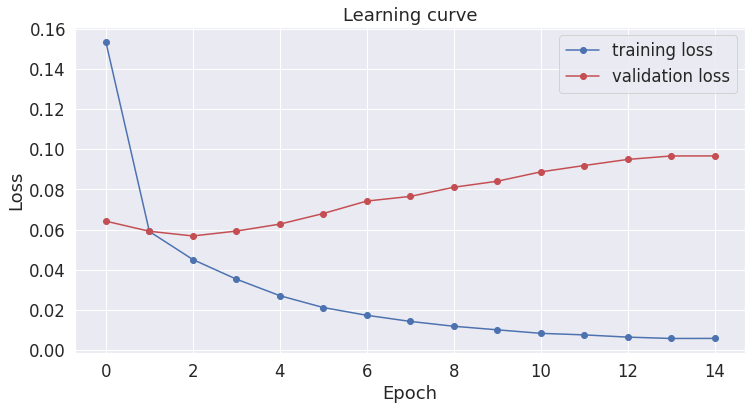

In [35]:
import matplotlib.pyplot as plt
%matplotlib inline

import seaborn as sns

# Use plot styling from seaborn.
sns.set(style='darkgrid')

# Increase the plot size and font size.
sns.set(font_scale=1.5)
plt.rcParams["figure.figsize"] = (12,6)

# Plot the learning curve.
plt.plot(loss_values, 'b-o', label="training loss")
plt.plot(validation_loss_values, 'r-o', label="validation loss")

# Label the plot.
plt.title("Learning curve")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.legend()

plt.show()
